#  QUESTION PRACTICE
# Structural Dynamics - Eigen Value Analysis Of Mdof System


**Question: Find the natural time period of the following building**
| Floor | Lumped Mass | Stiffness of Individual Column in Story |
|--|--|--|
| 1st | 2 $kips \cdot s^2 /inch$ | 1800 $kips /inch$ |
| 2nd | 1.5 $kips \cdot s^2 /inch$ | 1200 $kips /inch$ |
| 3rd | 1 $kips \cdot s^2 /inch$ | 600 $kips /inch$ |

**The model has lumped mass at each story and only 3 DoFs**
Answer: 
- Fundamental Time Period = $.432 s$ 

In [1]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt


## Units Conversion

In [2]:
#length conversion
m = 1.0
cm = 0.01*m # centimeter, needed for displacement input in MultipleSupport excitation
mm = 0.001*m
inch = m/39.37
ft = 12.*inch 

#area conversion
sqinch = inch**2
inch4 = inch**4

#ksi to pa
pa = 1.0
kpa = 1000*pa
Mpa = 1000*kpa
ksi = 6.89*1000*kpa  #ksi = kip / sqinch
psi = ksi/1000.


#kip to kN
N = 1.0
kN = 1000 * N
kip = 4.45 * kN

# pound to kg
kg = 1 
pound = 0.453592 * kg
lbf = psi*inch**2  #pounds force
pcf = lbf/pow(ft, 3) #pounds per cubic foot
psf = lbf/pow(ft, 2) #pounds per square foot


# acceleration due to gravity
g = 9.81 #m/s^2

#time
sec = 1.0


## Model Variables

- For time period analysis we will calculate section dimensions based on given data for stiffness of each column in story

In [6]:
### GEOMETRIC DATA ###
# storey height: 
h = 120.*inch       #same height for all storey 

storey = h
span = 2. *storey

x_coors = np.array([0.0, span])
y_coors = np.array([0.0, storey, 2 * storey, 3*storey])


# masses
mass_floor = np.array([9000, 7500, 5000])*kg
## 1st floor, 2nd floor, 3rd floor
#floor stiffness
k_floor = np.array([35e4, 25e4, 15e4])*N/m
## 1st floor, 2nd floor, 3rd floor
E = 2e11 * N/m**2


# finding section data using E, h and k
I_floor = (k_floor/2)*h**3/(12*E)
b_col = (I_floor*12)**(1/4)
A_col = b_col**2


numModes = 3





## Model Definition

<Axes: >

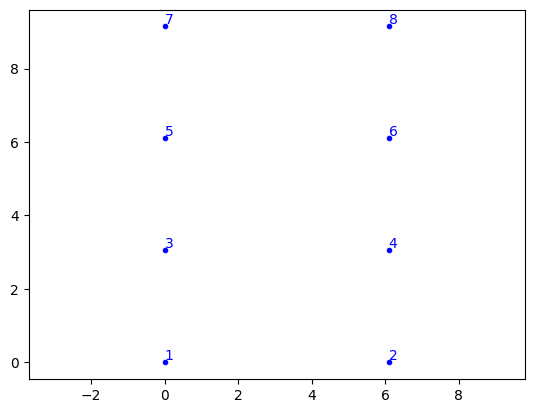

In [7]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)
#defining nodes

for j,y in enumerate(y_coors):
    for i,x in enumerate(x_coors):
        nodeTag = i + j * len(x_coors) + 1 
        ops.node(nodeTag, *[x, y])

ovs.plot_model()

In [8]:
ops.fix(1 , *[1,1,1])
ops.fix(2, *[1,1,1])

In [9]:
#assigning mass at nodes 3,4,5,6
#Masses are assigned at nodes 3, 4, 5, and 6 using mass command. 
#Since the considered shear frame system has only two degrees of freedom (displacements in x at the 1st and the 2nd storey),
#the masses have to be assigned in x direction only.

ops.mass(3, *[mass_floor[0]/2 , 0, 0])
ops.mass(4, *[mass_floor[0]/2, 0, 0])
ops.mass(5, *[mass_floor[1]/2, 0, 0])
ops.mass(6, *[mass_floor[1]/2, 0, 0])
ops.mass(7, *[mass_floor[2]/2, 0, 0])
ops.mass(8, *[mass_floor[2]/2, 0, 0])

In [10]:
#The geometric transformation with id tag 1 is defined to be linear.

linTrans = 1
pDelta = 2
ops.geomTransf('Linear', linTrans)

In [11]:

#create elastic element with following properties:
# 1 = tag for the element as shown in fig 2 
# 1, 3 = between nodes 1 and 3
# Ac/Ab  Area of column/beam
# Ic\Ib Mom. of inertia of column\beam
# Ec/Eb = Modulus of elasticity of Column/Beam


Ab = np.max(A_col)
Ib = 100*np.max(I_floor)
Ec = E

ops.element('elasticBeamColumn', 1, *[1, 3], A_col[0], Ec, I_floor[0], linTrans)
ops.element('elasticBeamColumn', 2, *[3, 5], A_col[1], Ec, I_floor[1], linTrans)
ops.element('elasticBeamColumn', 3, *[5, 7], A_col[2], Ec, I_floor[2], linTrans)
ops.element('elasticBeamColumn', 4, *[2, 4], A_col[0], Ec, I_floor[0], linTrans)
ops.element('elasticBeamColumn', 5, *[4, 6], A_col[1], Ec, I_floor[1], linTrans)
ops.element('elasticBeamColumn', 6, *[6, 8], A_col[2], Ec, I_floor[2], linTrans)
ops.element('elasticBeamColumn', 7, *[3, 4], Ab, Ec, Ib, linTrans)
ops.element('elasticBeamColumn', 8, *[5, 6], Ab, Ec, Ib, linTrans)
ops.element('elasticBeamColumn', 9, *[7, 8], Ab, Ec, Ib, linTrans)

<Axes: >

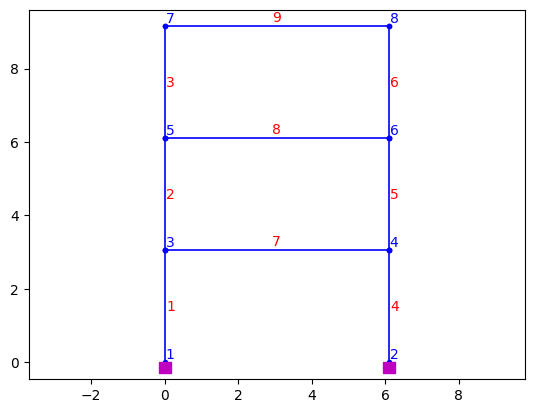

In [12]:
ovs.plot_model()

**To comply with the assumptions of the shear frame (no vertical displacemnts and rotations at nodes) end nodes of the beams are constrained to each other in the 2nd DOF (vertical displacement) and the 3rd DOF (rotation). EqualDOF command is used to imply these constraints.**

In [13]:
ops.equalDOF(3, 4, 2, 3)  #follow refrence node 3 and apply it to node 4 and constraint the 2nd dof(vertical displacement) and 3rd DOF(rotation)
ops.equalDOF(5, 6, 2, 3) 
ops.equalDOF(7, 8, 2, 3) 




### equalDOF Constraints in OpenSees
The equalDOF command in OpenSees is used to define a multi-point constraint between nodes. This means it allows you to tie the degrees of freedom (DOFs) of one node to the corresponding DOFs of another node. In simpler terms, the constrained node will mimic the movements and rotations of the reference node for the specified DOFs.

Here's a breakdown of what you need to know about equalDOF:

**Purpose:**

Enforce equal displacements and rotations (DOFs) between multiple nodes.
Useful for modeling rigid elements, diaphragms, or connecting points where nodes should move together.
Command format:

`equalDOF nd1 dof1_1 dof1_2 ... dof1_n nd2 dof2_1 dof2_2 ... dof2_n`
* `nd1`: Tag of the reference node (node whose DOFs are followed)
* `dof1_i`: List of DOFs at `nd1` to be constrained (1-ndf, ndf being the number of nodal DOFs)
* `nd2`: Tag of the constrained node (node whose DOFs follow `nd1`)
* `dof2_i`: List of DOFs at `nd2` to be constrained (corresponding to `dof1_i`)

**Example:**
`equalDOF 2 1 3 5 3 1 3 5;`
This command enforces the following:

- The x-translation (DOF 1), z-translation (DOF 3), and y-rotation (DOF 5) of node 3 will be equal to the corresponding DOFs of node 2.

**Key points to remember:**

- You can specify any number of DOFs from both nodes.
- The order of DOFs listed for each node should be the same.
- equalDOF creates a penalty-based constraint, meaning a large stiffness is applied to enforce the equal DOF condition.
- Choose a penalty stiffness large enough to effectively enforce the constraint without causing numerical issues.
- Use equalDOF with caution for large models as it can increase computational cost.

**Additional resources:**

OpenSees Documentation: https://opensees.berkeley.edu/wiki/index.php/EqualDOF_command
OpenSeesWiki: https://opensees.berkeley.edu/wiki/index.php/EqualDOF_command
I hope this explanation helps! Feel free to ask if you have any further questions about equalDOF or OpenSees in general.




#### For the specified number of eigenvalues (numModes) (for this example it is 3) the eigenvectors are recorded at all nodes in all DOFs using node recorder command

In [14]:
#eigen value analysis
lamda = ops.eigen(numModes)

omegas = []
freqs = []
T = []
for lam in lamda:
    omega = np.sqrt(lam)
    freq  = omega/(2*np.pi)
    omegas.append(omega)
    freqs.append(freq)
    T.append(1/freq)

In [15]:
omegas

[2.9501783254166374, 6.752429705509158, 9.739876414292489]

In [35]:
print(f"The time period at 3 modes are: {T}")
print(f"The Fundamental period is: {max(T)}")
print(f"The Fundamental frequency is: {min(freqs)}")

The time period at 3 modes are: [0.042487097401361355, 0.019370538721770022, 0.012666983620939907]
The Fundamental period is: 0.042487097401361355
The Fundamental frequency is: 23.536557241209856


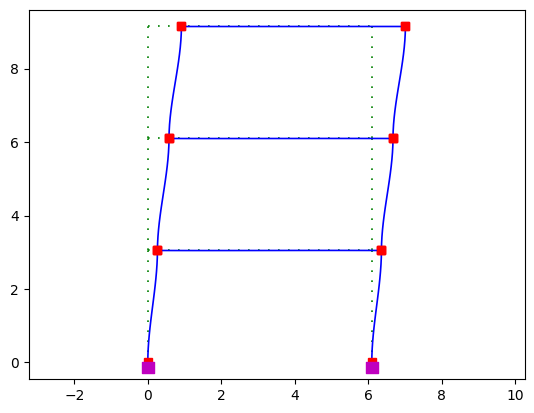

In [36]:
ovs.plot_mode_shape(1)

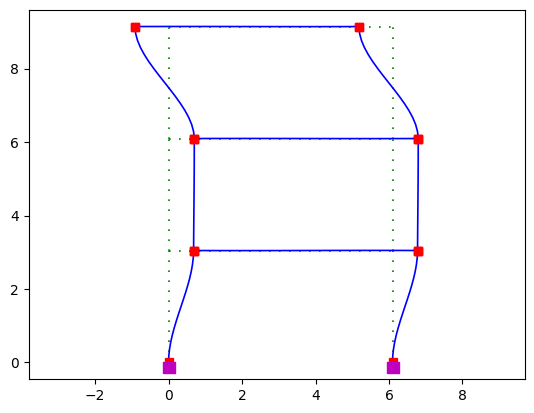

In [37]:
ovs.plot_mode_shape(2)

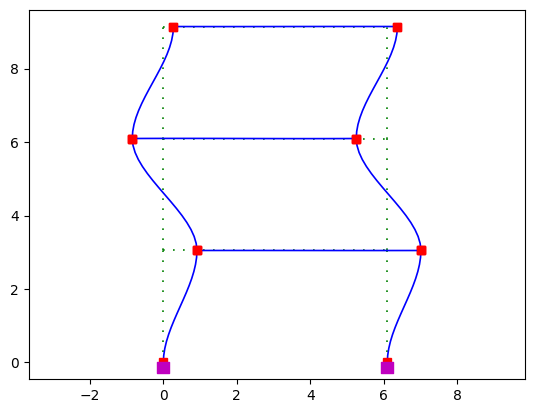

In [38]:
ovs.plot_mode_shape(3)

### Lets try getting eigen vectors for each modes of vibration and plot by ourself

In [39]:
right_nodes = [2, 4, 6, 8]

mode_1 = []
mode_2 = []
mode_3 = []


print(mode_1, mode_2, mode_3)

for imode in range(3):
    print(f'\nMode {imode+1}')
    for node in right_nodes:
        eig_val = ops.nodeEigenvector(node, imode+1, 1)
        print(f"node {node} ", eig_val)
        exec(f'mode_{int(imode+1)}.append(eig_val)')


print(mode_1)
print(mode_2)
print(mode_3)

[] [] []

Mode 1
node 2  0.0
node 4  0.01813356044201636
node 6  0.03988503808826786
node 8  0.06322606233526487

Mode 2
node 2  0.0
node 4  0.037003805826638037
node 6  0.03796777225979051
node 8  -0.049623196357607736

Mode 3
node 2  0.0
node 4  0.047978040185487056
node 6  -0.044357998222711824
node 8  0.014376024885140422
[0.0, 0.01813356044201636, 0.03988503808826786, 0.06322606233526487]
[0.0, 0.037003805826638037, 0.03796777225979051, -0.049623196357607736]
[0.0, 0.047978040185487056, -0.044357998222711824, 0.014376024885140422]


In [40]:

mode_1 = np.array(mode_1)/mode_1[3]
mode_2 = np.array(mode_2)/mode_2[3]
mode_3 = np.array(mode_3)/mode_3[3]

In [41]:

print(mode_1)
print(mode_2)
print(mode_3)

[0.         0.28680515 0.63083223 1.        ]
[-0.         -0.74569573 -0.76512146  1.        ]
[ 0.          3.33736485 -3.0855538   1.        ]


In [42]:
mode_1       #gives eigen vectors for mode_1 (1st floor, 2nd floor and 3rd floor)

array([0.        , 0.28680515, 0.63083223, 1.        ])

In [43]:
y_coors

array([0.        , 3.0480061 , 6.09601219, 9.14401829])

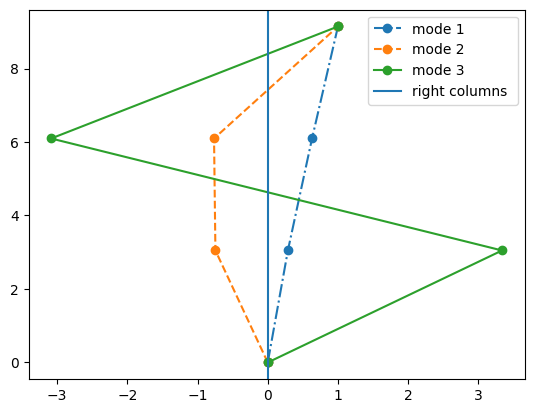

In [44]:
plt.plot(mode_1, y_coors, '-.o', label='mode 1')
plt.plot(mode_2, y_coors, '--o', label='mode 2')
plt.plot(mode_3, y_coors, '-o', label='mode 3')
plt.axvline(0, label='right columns ')
plt.legend()

### This is straight line and not much intuitative, lets try to plot with smooth fitted lines

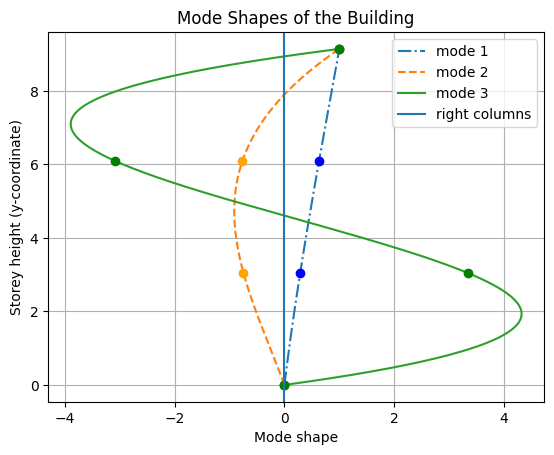

In [45]:
from scipy.interpolate import interp1d, splrep, splev


# Generate a dense range of y-coordinates for smooth plotting
y_dense = np.linspace(y_coors.min(), y_coors.max(), 300)

# Interpolate each mode shape
mode_1_smooth = splev(y_dense, splrep(y_coors, mode_1))
mode_2_smooth = splev(y_dense, splrep(y_coors, mode_2))
mode_3_smooth = splev(y_dense, splrep(y_coors, mode_3))

# Plot the smooth curves
plt.plot(mode_1_smooth, y_dense, '-.', label='mode 1')
plt.plot(mode_2_smooth, y_dense, '--', label='mode 2')
plt.plot(mode_3_smooth, y_dense, '-', label='mode 3')
plt.plot(mode_1, y_coors, 'o', c='blue')
plt.plot(mode_2, y_coors, 'o', c='orange')
plt.plot(mode_3, y_coors, 'o', c='green')

plt.axvline(0, label='right columns')
plt.legend()
plt.xlabel('Mode shape')
plt.ylabel('Storey height (y-coordinate)')
plt.title('Mode Shapes of the Building')
plt.grid(True)
plt.show()

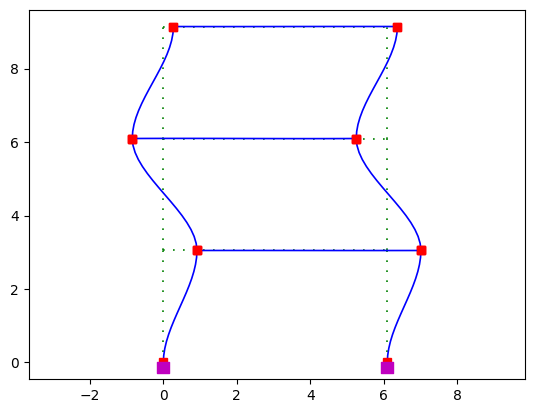

In [46]:
ovs.plot_mode_shape(3)